# Product Clustering - Amazon Reviews Dataset

## Project Title:
**Product Category Clustering Using NLP**

---

## Goal:
Cluster Amazon products into **4–6 meaningful categories** using Natural Language Processing (NLP) techniques. These clusters will help simplify product organization and improve insights for downstream tasks like review summarization and recommendations.

---

## Procedure:

###  1. Text Preprocessing
- Combine the product `name` with the **most specific product category** (last item in the category list).
- Create a new text field (`text_for_clustering`) for embedding and clustering.

###  2. Text Embedding using Sentence Transformers
- Use a pretrained transformer model: **`all-MiniLM-L6-v2`** from the `sentence-transformers` library.
- Convert product text into dense vector embeddings that capture semantic meaning.

### 3. Clustering Experiments
Apply multiple clustering algorithms to discover natural groupings in the data:
- **KMeans** (with Elbow and Silhouette analysis to choose optimal `k`)
- **Agglomerative Clustering** (hierarchical clustering)
- **HDBSCAN** (density-based clustering, good for irregular cluster shapes)

###  4. Dimensionality Reduction & Visualization
- Use **UMAP** (Uniform Manifold Approximation and Projection) to reduce high-dimensional embeddings to 2D.
- Visualize the clusters in 2D space for interpretability and validation.

###  5. Cluster Evaluation and Selection
Evaluate and compare clustering methods based on:
- **Silhouette Score**
- **Visual separation** of clusters (via UMAP)
- **Interpretability** for business use cases

---

## Final Output:
A labeled set of product clusters that group similar items together, ready for downstream tasks like:
- Summarizing reviews per category using LLMs
- Recommending top products
- Enhancing product taxonomy




In [3]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import DistilBertTokenizer, DistilBertModel
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt



#Step 1: Load and Clean Data

In [4]:
import pandas as pd

# Load your dataset (adjust the path as needed)
#df = pd.read_csv(r"/content/cleaned_reviews_with_final_sentiment.csv")
df = pd.read_csv("/content/1429_1.csv")

# Check for missing values in 'name' and 'categories' columns
print("Missing values in 'name' and 'categories':")
print(df[['name', 'categories']].isnull().sum())

Missing values in 'name' and 'categories':
name          6760
categories       0
dtype: int64


<ipython-input-4-3229395215>:5: DtypeWarning: Columns (1,10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("/content/1429_1.csv")


#Step 2: Clean and prepare text for clustering

In [5]:
# Check missing values
print("Missing values in 'name' and 'categories':")
print(df[['name', 'categories']].isnull().sum())

# Drop missing rows and duplicates
df = df.dropna(subset=['name', 'categories'])
df = df.drop_duplicates(subset='name').reset_index(drop=True)

# Convert 'categories' from string to list
df['categories'] = df['categories'].apply(lambda x: x.split(',') if isinstance(x, str) else [])

# Define clean_text function to combine name and last category
def clean_text(row):
    categories = row['categories']
    if categories:  # already a list, check if non-empty
        most_specific_cat = categories[-1]
    else:
        most_specific_cat = ""
    return f"{row['name']} {most_specific_cat}"

# Create the combined text column for clustering
df['text_for_clustering'] = df.apply(clean_text, axis=1)



Missing values in 'name' and 'categories':
name          6760
categories       0
dtype: int64


 # Step 3: Generate Sentence Embeddings

In [6]:
from sentence_transformers import SentenceTransformer

# Load pretrained model
model = SentenceTransformer('all-MiniLM-L6-v2')

# Generate embeddings from text_for_clustering column
print("Generating embeddings...")
embeddings = model.encode(df['text_for_clustering'].tolist(), show_progress_bar=True)


Generating embeddings...


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

#Step 4: Elbow Method (for KMeans)

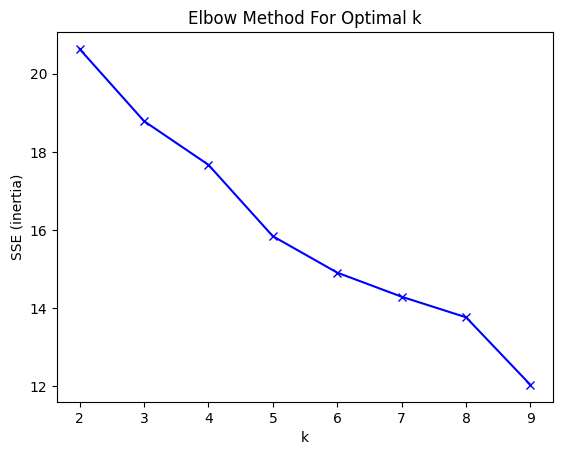

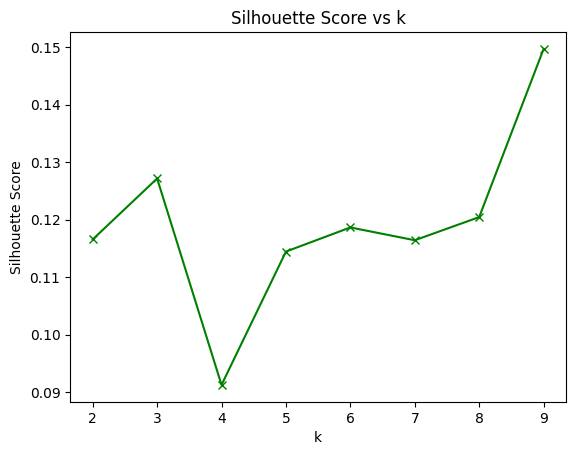

In [7]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

sse = []
silhouette_scores = []
k_range = range(2, 10)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(embeddings)
    sse.append(kmeans.inertia_)  # Sum of squared errors
    silhouette_scores.append(silhouette_score(embeddings, labels))

# Elbow Plot
plt.plot(k_range, sse, 'bx-')
plt.xlabel('k')
plt.ylabel('SSE (inertia)')
plt.title('Elbow Method For Optimal k')
plt.show()

# Silhouette Score Plot
plt.plot(k_range, silhouette_scores, 'gx-')
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs k')
plt.show()


# Step 5: Clustering (KMeans, AgglomerativeClustering,DBSCAN)

In [8]:
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score
import hdbscan

# Set number of clusters for fixed-k methods (adjust based on your elbow/silhouette plots)
optimal_k = 5

# 1) KMeans Clustering
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
df['kmeans_cluster'] = kmeans.fit_predict(embeddings)

kmeans_silhouette = silhouette_score(embeddings, df['kmeans_cluster'])
print(f"KMeans: Number of clusters = {len(set(df['kmeans_cluster']))}")
print(f"KMeans Silhouette Score = {kmeans_silhouette:.4f}")

# 2) Agglomerative Clustering
agglo = AgglomerativeClustering(n_clusters=optimal_k)
df['agglo_cluster'] = agglo.fit_predict(embeddings)

agglo_silhouette = silhouette_score(embeddings, df['agglo_cluster'])
print(f"Agglomerative Clustering: Number of clusters = {len(set(df['agglo_cluster']))}")
print(f"Agglomerative Silhouette Score = {agglo_silhouette:.4f}")

# 3) HDBSCAN Clustering
# Tune min_cluster_size and min_samples if you get only one cluster or too many noise points
hdb = hdbscan.HDBSCAN(min_cluster_size=5, min_samples=1)
df['hdbscan_cluster'] = hdb.fit_predict(embeddings)

num_hdb_clusters = len(set(df['hdbscan_cluster'])) - (1 if -1 in df['hdbscan_cluster'].values else 0)
num_noise_points = (df['hdbscan_cluster'] == -1).sum()

print(f"HDBSCAN: Number of clusters = {num_hdb_clusters}")
print(f"HDBSCAN: Number of noise points = {num_noise_points}")

# Silhouette score for HDBSCAN only if more than 1 cluster
if num_hdb_clusters > 1:
    hdb_silhouette = silhouette_score(embeddings[df['hdbscan_cluster'] != -1], df['hdbscan_cluster'][df['hdbscan_cluster'] != -1])
    print(f"HDBSCAN Silhouette Score = {hdb_silhouette:.4f}")
else:
    print("HDBSCAN Silhouette Score: Not applicable (only one cluster or all noise)")


KMeans: Number of clusters = 5
KMeans Silhouette Score = 0.1145
Agglomerative Clustering: Number of clusters = 5
Agglomerative Silhouette Score = 0.1328
HDBSCAN: Number of clusters = 2
HDBSCAN: Number of noise points = 4
HDBSCAN Silhouette Score = 0.1282


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


# Step 6: Visulization of Cluster using umap

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


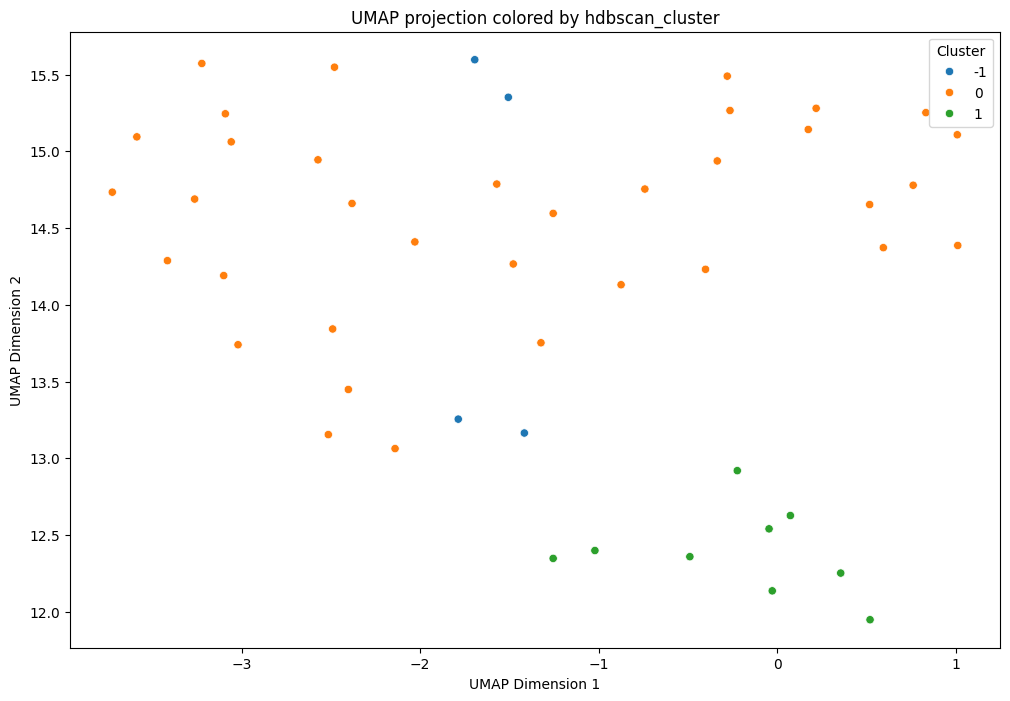

In [9]:
import umap.umap_ as umap
import seaborn as sns
import matplotlib.pyplot as plt

# UMAP dimensionality reduction
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42)
embedding_2d = reducer.fit_transform(embeddings)

# Add 2D embedding for plotting
df['UMAP_1'] = embedding_2d[:, 0]
df['UMAP_2'] = embedding_2d[:, 1]

# --- Choose one of the cluster columns to visualize ---
cluster_column = 'hdbscan_cluster'  # or ["kmeans_cluster" 'agglo_cluster' or 'hdbscan_cluster']

plt.figure(figsize=(12, 8))
palette = sns.color_palette("tab10", len(df[cluster_column].unique()))

sns.scatterplot(
    x='UMAP_1', y='UMAP_2',
    hue=df[cluster_column],
    palette=palette,
    data=df,
    legend='full'
)

plt.title(f"UMAP projection colored by {cluster_column}")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.legend(title='Cluster')
plt.show()


# Step 7:  Cluster Summary and Inspection

In [10]:
def clean_product_text(text, max_len=80):
    # Remove unwanted line breaks and extra commas
    text = text.replace('\r', ' ').replace('\n', ' ')
    text = text.replace(',,,', '').strip()
    # Truncate to max_len chars, add ellipsis if needed
    if len(text) > max_len:
        text = text[:max_len].rstrip() + "..."
    return text

def cluster_summary(df, cluster_col, text_col='text_for_clustering', sample_size=3):
    summary = []
    clusters = sorted(df[cluster_col].dropna().unique())

    for cluster_num in clusters:
        cluster_data = df[df[cluster_col] == cluster_num]
        sample_texts = cluster_data[text_col].sample(min(sample_size, len(cluster_data))).values
        cleaned_samples = [clean_product_text(s) for s in sample_texts]
        summary.append({
            'Cluster': cluster_num,
            'Count': len(cluster_data),
            'Sample Products': " | ".join(cleaned_samples)
        })
    return pd.DataFrame(summary)

# Example: summary for KMeans
kmeans_summary = cluster_summary(df, 'kmeans_cluster')
print(kmeans_summary.to_string(index=False))


 Cluster  Count                                                                                                                                                                                                                                                 Sample Products
       0     10 Amazon Echo and Fire TV Power Adapter  Amazon Echo and Fire TV Power Adapter  Wi... | Certified Refurbished Amazon Fire TV Stick (Previous Generation - 1st)  Certifie... | Certified Refurbished Amazon Fire TV with Alexa Voice Remote  Certified Refurbis...
       1      9      New Amazon Kindle Fire Hd 9w Powerfast Adapter Charger + Micro Usb Angle Cable... | Amazon 9W PowerFast Official OEM USB Charger and Power Adapter for Fire Tablets... | New Amazon Kindle Fire Hd 9w Powerfast Adapter Charger + Micro Usb Angle Cable...
       2      8 Amazon Fire Tv  Kindle Dx Leather Cover, Black (fits 9.7 Display, Latest and 2nd... | Amazon Fire Hd 6 Standing Protective Case(4th Generation - 2014 Release), Cayenn..

# Step 8: Saving Initial Cluster Mappings

In [12]:
# Select columns you want to save (name + clusters)
category_cluster_df = df[['name', 'kmeans_cluster', 'agglo_cluster', 'hdbscan_cluster']].drop_duplicates()

# Save to CSV
category_cluster_df.to_csv('category_cluster_mapping.csv', index=False)


In [17]:
df.to_csv('full_data_with_clusters.csv', index=False)


# Step 9: Extracting Last Category and Merging with Product IDs

In [14]:
# Extract the last category into a new column
df['category'] = df['categories'].apply(lambda x: x[-1] if isinstance(x, list) and len(x) > 0 else None)

# Load your clustering mapping (should contain columns: name, kmeans_cluster, etc.)
mapping_df = pd.read_csv("/content/category_cluster_mapping.csv")

# Merge on 'name' instead of 'category'
merged = pd.merge(df[['id', 'name']], mapping_df, on='name', how='inner')

# Save to CSV
output_path = "category_cluster_with_id.csv"
merged.to_csv(output_path, index=False)

print(f"✅ Done! Saved merged file with ID, name, and cluster info to: {output_path}")


✅ Done! Saved merged file with ID, name, and cluster info to: category_cluster_with_id.csv


#Step 10: Verifying Cluster Distribution

In [15]:
import pandas as pd

# Load your cluster data
# Assuming your CSV is named 'category_cluster_with_id.csv' from previous steps
try:
    cluster_data = pd.read_csv("/content/category_cluster_with_id.csv")
    print("CSV loaded successfully.")
except FileNotFoundError:
    print("Error: 'category_cluster_with_id.csv' not found. Please ensure the file exists.")
    exit()

# --- Check the number of products in each KMeans cluster ---
if 'kmeans_cluster' in cluster_data.columns:
    print("\n--- Product Count per KMeans Cluster ---")
    print(cluster_data['kmeans_cluster'].value_counts().sort_index())
else:
    print("\n'kmeans_cluster' column not found in the DataFrame.")

# --- Check the number of products in each Agglomerative cluster ---
if 'agglo_cluster' in cluster_data.columns:
    print("\n--- Product Count per Agglomerative Cluster ---")
    print(cluster_data['agglo_cluster'].value_counts().sort_index())
else:
    print("\n'agglo_cluster' column not found in the DataFrame.")

# --- Check the number of products in each HDBSCAN cluster ---
if 'hdbscan_cluster' in cluster_data.columns:
    print("\n--- Product Count per HDBSCAN Cluster ---")
    # HDBSCAN's -1 cluster represents noise points, which value_counts() will include.
    # You might want to handle this separately or note that -1 is noise.
    print(cluster_data['hdbscan_cluster'].value_counts().sort_index())
    num_noise_points = (cluster_data['hdbscan_cluster'] == -1).sum()
    if num_noise_points > 0:
        print(f"(Note: Cluster -1 represents {num_noise_points} noise points in HDBSCAN)")
else:
    print("\n'hdbscan_cluster' column not found in the DataFrame.")

CSV loaded successfully.

--- Product Count per KMeans Cluster ---
kmeans_cluster
0    10
1     9
2     8
3    13
4     8
Name: count, dtype: int64

--- Product Count per Agglomerative Cluster ---
agglo_cluster
0    22
1    10
2     6
3     8
4     2
Name: count, dtype: int64

--- Product Count per HDBSCAN Cluster ---
hdbscan_cluster
-1     4
 0    35
 1     9
Name: count, dtype: int64
(Note: Cluster -1 represents 4 noise points in HDBSCAN)


In [16]:
cluster_data

,id,name,kmeans_cluster,agglo_cluster,hdbscan_cluster
0,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",3,0,0
1,AVqVGZO3nnc1JgDc3jGK,Kindle Oasis E-reader with Leather Charging Co...,4,3,0
2,AVpe9CMS1cnluZ0-aoC5,"Amazon Kindle Lighted Leather Cover,,,\r\nAmaz...",2,1,0
3,AVpe9CMS1cnluZ0-aoC5,"Amazon Kindle Lighted Leather Cover,,,\r\nKind...",2,1,0
4,AVpe9CMS1cnluZ0-aoC5,"Kindle Keyboard,,,\r\nKindle Keyboard,,,",2,1,0
5,AVpfBEWcilAPnD_xTGb7,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",3,0,0
6,AVqkIiKWnnc1JgDc3khH,"Fire HD 8 Tablet with Alexa, 8 HD Display, 32 ...",3,0,0
7,AVqkIj9snnc1JgDc3khU,Amazon 5W USB Official OEM Charger and Power A...,1,2,1
8,AVsRjfwAU2_QcyX9PHqe,"All-New Kindle E-reader - Black, 6 Glare-Free ...",4,3,0
9,AVsRjfwAU2_QcyX9PHqe,"Amazon Kindle Fire Hd (3rd Generation) 8gb,,,\...",4,3,0


# Final Summary & Conclusion



This notebook demonstrated product clustering using NLP techniques on an Amazon reviews dataset. By leveraging semantic sentence embeddings from the all-MiniLM-L6-v2 model, we were able to capture meaningful textual representations of products by combining their names with specific category information.

Three clustering algorithms—KMeans, Agglomerative Clustering, and HDBSCAN—were applied to these embeddings, and 5 clusters were identified using KMeans and Agglomerative methods. UMAP was used for dimensionality reduction and visualization, helping to intuitively assess the quality and separation of clusters.

Key outcomes:

    Semantic Embedding enabled grouping similar products based on meaning, not just keyword overlap.

    KMeans with k=5 offered clear and interpretable clusters.

    Cluster summaries provided insights into the product types in each group.

    Cluster mappings were saved and merged with product IDs for downstream use.

This approach can enhance product taxonomy, support personalized recommendations, or assist in category-specific review analysis.